# Missing-GPS Gem Data Pre-Processing Workflow
This demo is intended only for datasets with GPS data at the beginning and end, but not in the middle. This could happen in mobile data recording projects including places where the GPS fix is typically lost, e.g. high-altitude balloons or indoor recording, or due to an instrument malfunction. You would normally find out this is a problem from warnings when you run `gemconvert`. 

If you don't know you have GPS problems, you shouldn't follow this workflow--follow the one in the `demo_conversion/` folder instead.

Warning: Frequent GPS fixes are essential for precise timekeeping, so sample times in the data converted with this method should NOT be considered precise. Typical clock drifts can be around 10-30 ppm (1-3 seconds per day).

### Installing the gemlog software (version 1.1.0 or higher)
Follow the gemlog installation procedure [here](https://github.com/ajakef/gemlog/blob/main/README.md). Note that the resulting conda environment includes relevant packages like obspy and pandas.

This demo converts raw data where some files lack GPS fixes (contained in `raw_missing_gps`) and compares it to otherwise identical raw and converted data that do contain gps fixes. 
```
Project_Folder/
|__raw_with_gps/ (ordinary raw data)
|__converted_with_gps (already-converted data using GPS info)
|__raw_missing_gps/ (raw data with the GPS info removed)
```

This example includes four two-hour files from one data logger. Files 0000 and 0003 do have GPS data; files 0001-0002 do not.
```
$ ls raw_missing_gps
FILE0000.077
FILE0001.077
FILE0002.077
FILE0003.077

$ grep -l '^G,' raw_missing_gps/* # find files containing GPS data lines (starting with 'G')
raw_missing_gps/FILE0000.077
raw_missing_gps/FILE0003.077
```
Gem data files have the Gem's serial number as the extension, meaning that we have data from Gem 077 only. Empty or nearly-empty data files (like those from quick tests between field campaigns) can cause problems in the data conversion. It's a good idea to start each field campaign with clean disks, and to inspect your raw files and remove bad files before converting them.


### I have a raw file with no GPS info and I don't care about timekeeping, just give me the data!
This is the simplest case. Use the `gemconvert_single` command to turn a single raw file into a single miniSEED file:



In [1]:
!gemconvert_single -f -i raw_missing_gps/FILE0001.077

gemlog version 1.6.5
input_file  raw_missing_gps/FILE0001.077
 
accurate sample timing. Do not use the resulting data for array processing or
anything else that requires accurate times.
 
File 1 of 1: raw_missing_gps/FILE0001.077


In [ ]:
`-f` is needed to force the conversion even without GPS data. 


### I have many contiguous raw files but some of them lack GPS data, and I want contiguous output data from it.

The following terminal command determines whether each raw file contains GPS data, and merges the files so that every output file has gps data at the beginning (and the end, if possible).

In [4]:
!gem_cat -i raw_missing_gps/ -o raw_merged -e 077

1 of 4: raw_missing_gps/FILE0000.077
2 of 4: raw_missing_gps/FILE0001.077
3 of 4: raw_missing_gps/FILE0002.077
4 of 4: raw_missing_gps/FILE0003.077
Files merged successfully. Remember: sample times in the output are NOT precise!


Input unmerged data files are in `raw_missing_gps/`, output merged files go in `raw_merged/`, and the serial number that it looks for to convert is 077.

##### Converting raw gem data
Now, convert the merged raw data files (all of which contain GPS info) to a standard format (in this case, miniSEED) using the following terminal command. This may take a while to run if you have a lot of data!

In [5]:
!gemconvert -i raw_merged -o converted_missing_gps -f mseed

gemlog version 1.6.5
inputdir  raw_merged
serial numbers  ['077']
outputdir  converted_missing_gps
File 1 of 1: raw_merged/FILE0000.077
.077..HDF | 2020-04-24T21:59:10.000000Z - 2020-04-24T23:59:59.990000Z | 100.0 Hz, 725000 samples
.077..HDF | 2020-04-25T00:00:00.000000Z - 2020-04-25T05:59:10.500000Z | 100.0 Hz, 2155051 samples
077 done


This command will add the following folders to your directory structure:
```
Project_Folder/
|__raw_with_gps/ (unchanged)
|__raw_missing_gps/ (unchanged)
|__raw_merged/ (unchanged)
|__converted_missing_gps (NEW: contains hour-long miniSEED waveform files)
|__metadata/ (NEW: contains csv files with state-of-health data)
|__gps/ (NEW: contains gps logs)
|__gemconvert_logfile.txt (NEW: contains a record of the conversion process and any messages)
```

By now, all the useful information has been extracted from the raw files; there is no reason to work with them further except for possible debugging. For more info on the gemconvert options and capabilities (e.g., the ability to write SAC files and the text format TSPAIR), run `gemconvert -h`.

##### Multiple conversion attempts
If the conversion is run multiple times, `gemconvert` will overwrite pre-existing miniSEED files. However, gps and metadata files are tagged with a conversion number at the end of their file name, so they are not overwritten. For a given Gem serial number, the file with the highest conversion number was created most recently. `gemconvert_logfile.txt` is appended to on each conversion attempt, so it is also not overwritten.


### Inspect the Data
The following workflow can be used to read the renamed mseed data and deconvolve the instrument response.
Because wind noise is severe at lower frequencies, it is generally necessary to apply a high-pass filter to obtain good data; 1 Hz is a good corner frequency to start with. Obspy's plot functions do not handle long plotting periods well; a program like PASSCAL's PQL is probably better for perusing the data.


2 Trace(s) in Stream:
.077..HDF | 2020-04-24T21:59:10.000000Z - 2020-04-24T23:59:59.990000Z | 100.0 Hz, 725000 samples
.077..HDF | 2020-04-25T00:00:00.000000Z - 2020-04-25T05:59:10.500000Z | 100.0 Hz, 2155051 samples
1 Trace(s) in Stream:
.077..HDF | 2020-04-24T21:59:10.000000Z - 2020-04-25T05:59:10.500000Z | 100.0 Hz, 2880051 samples


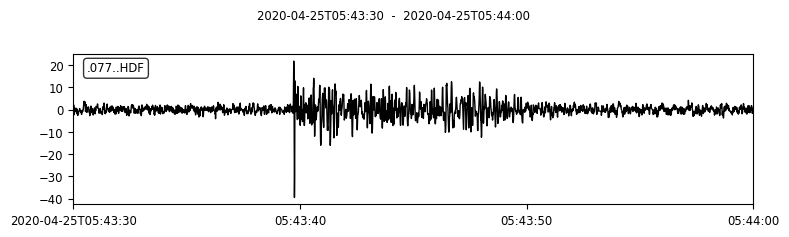

In [12]:
import obspy

## read the data
testdata = obspy.read('converted_missing_gps/*')
print(testdata)

## combine traces 
testdata.merge()
print(testdata)

## filter data above 1 Hz (lower frequencies are often wind noise)
testdata.filter("highpass", freq=1.0)

## trim the data around a known event
t1 = obspy.UTCDateTime('2020-04-25T05:43:30')
t2 = obspy.UTCDateTime('2020-04-25T05:44:00')
testdata.trim(t1, t2)

## plot the results
testdata.plot()
print() # just to avoid repeat plots

Finally, we can look at the ordinary data without the GPS info removed as a comparison:

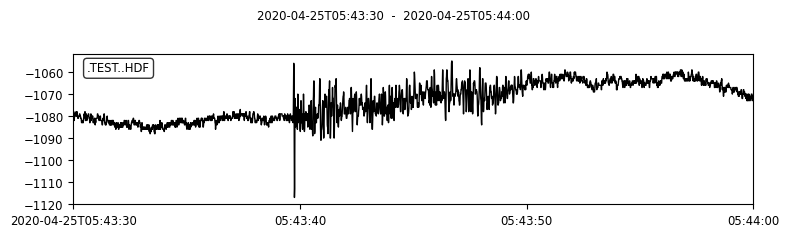

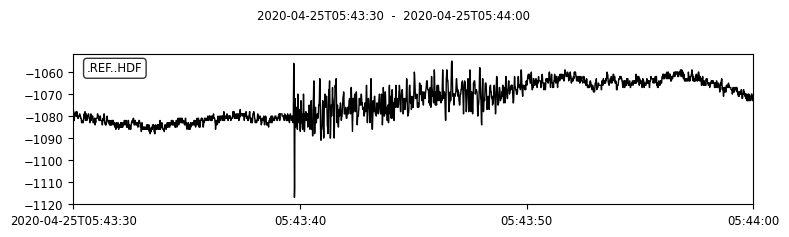

In [11]:
testdata = obspy.read('converted_missing_gps/*')
testdata.trim(t1, t2)
testdata[0].stats.station = 'TEST'
testdata.plot()

reference = obspy.read('converted_with_gps/*')
reference.trim(t1, t2)
reference[0].stats.station = 'REF'
reference.plot()

print() # just to avoid repeat plots

### Subsequent analysis
The `obspy` package is a convenient and powerful environment for manipulating time-series data. However, if you want direct access to the waveform data to plug in to your own analysis, you can obtain it as follows:


In [10]:
reference[0].data # a numpy array (or masked array, if any samples are missing)


array([-1081, -1078, -1079, ..., -1071, -1071, -1070], dtype=int32)